- original paper :[here](https://arxiv.org/abs/1503.03832)
- dataset [here](http://vis-www.cs.umass.edu/lfw/), paper claims that they got 99.63% acc, cuts the error rate in comparison to the best published result [15] by 30%
- inspired by n [19] in the context of nearest-neighbor classification



**definition**
- online/offline
    - Generate triplets offline: find argmax/argmin (positive/negative) every n steps
    - Generate triplets online: "-------------------------------------" within a mini-batch
<br>

**Implementation (based on paper)**
- ensured that a minimal number of exemplars of any one identity is present in each mini-batch
- all anchor positive pairs in a mini-batch while still selecting the **hard** negatives. (They claim, it's more stable than with both **hard** neg&pos)
- hardest negatives can lead to local minima early on in training
- select semi-hard, argmin(f(x)) that still more than positive

- Stochastic Gradient Descent (SGD) with standard backprop and AdaGrad 
- start with a learning rate of 0.05, and lower over time
- margin α is set to 0.2
- use rectified linear units
- Input sizes range from 96x96 pixels to 224x224

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def random_dict(dict_obj):
    key = random.choice(list(dict_obj))
    return dict_obj[key]
def random_except(arr, except_value):
    random_value = random.choice(arr)
    if random_value == except_value:
        return random_except(arr, except_value)
    return random_value
class OneShotDataset(Dataset):
    
    def __init__(self, dataset, max_num_each_class=10):
        self.class_dict = {}
        self.dataset = dataset
        num_each_class = {}
        self.length = 0
        
        for i, (data, label) in enumerate(self.dataset):
            label_item = label.item()
            if label_item not in list(self.class_dict.keys()):
                self.class_dict[label_item] = []
                num_each_class[label_item] = 0
                
            if max_num_each_class is -1 or num_each_class[label_item] < max_num_each_class:
                self.class_dict[label_item].append((data, label))
                num_each_class[label_item] += 1
                self.length += 1
        
    def __getitem__(self, index):
        
        # anchor
        image_anchor, class_anchor_tensor = random.choice(random_dict(self.class_dict))
        class_anchor = class_anchor_tensor.item()
        
        # positive
        image_positive, class_positive_tensor = random.choice(self.class_dict[class_anchor])
        if image_positive is image_anchor:
            # rerandom if anchor and positive are the same
            image_positive, class_positive_tensor = random.choice(self.class_dict[class_anchor])
            
        # negative
        class_negative = random_except(list(self.class_dict), class_anchor)
        image_negative, class_negative_tensor = random.choice(self.class_dict[class_negative])
        return image_anchor, image_positive, image_negative
        
    def __len__(self):
        return self.length

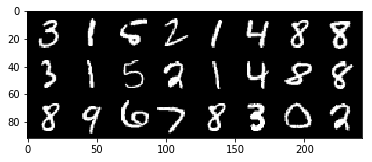

In [3]:
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transforms.ToTensor()))
data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=8)
example_batch = next(iter(data_loader_test))


concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


In [4]:
transform_train = transforms.Compose([
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = OneShotDataset(datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train))
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transform_test))
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)


In [5]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.Linear(500, 10)
        )
        self.is_classification = True
        
    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc(output)
        return output

    def forward(self, input_anchor, input_positive, input_negative):
        output1 = self.forward_once(input_anchor)
        output2 = self.forward_once(input_positive)
        output3 = self.forward_once(input_negative)
        return output1, output2, output3
    def name(self):
        return "LeNetOneShot"

In [6]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, input_data, output):
        anchor, positive, negative = output
        pos_dist   = F.pairwise_distance(anchor, positive)
        neg_dist   = F.pairwise_distance(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss

In [7]:
def input_to_model_mapper(*input_data):
    return input_data

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [8]:
model = LeNetOneShot()
criterion = TripletLoss(0.2)

def eval_func(loss, output, target):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(data_loader_train, data_loader_test, model, criterion, input_to_model_mapper)
learner.fit(0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
   [train] Average loss: 0.1871, acc: 65.00%
   [test] Average loss: 0.1136, acc: 79.00%
---- epoch:1 ------
   [train] Average loss: 0.1058, acc: 80.00%
   [test] Average loss: 0.0761, acc: 83.00%
---- epoch:2 ------
   [train] Average loss: 0.0572, acc: 89.00%
   [test] Average loss: 0.0820, acc: 85.00%
---- epoch:3 ------
   [train] Average loss: 0.0901, acc: 83.00%
   [test] Average loss: 0.0723, acc: 85.00%
---- epoch:4 ------
   [train] Average loss: 0.0612, acc: 88.00%
   [test] Average loss: 0.1019, acc: 85.00%
---- epoch:5 ------
   [train] Average loss: 0.0864, acc: 82.00%
   [test] Average loss: 0.0728, acc: 86.00%
---- epoch:6 ------
   [train] Average loss: 0.0648, acc: 84.00%
   [test] Average loss: 0.0962, acc: 82.00%
---- epoch:7 ------
   [train] Average loss: 0.0315, acc: 94.00%
   [test] Average loss: 0.0625, acc: 88.00%
---- epoch:8 ------
   [train] Average loss: 0.0424, acc: 92.00%
   [test] Average loss: 0.0671, acc: 85.00%
---- epoch:9 ------

### Finding threshod

In [9]:
def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        return (positive_distance < negative_distance).sum().item()
learner.predict(eval_func)

   [test] Average loss: 0.0400, acc: 92.00%


In [10]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        
        # positive
        positive_distance = F.pairwise_distance(anchor, positive)
        positive_correct = positive_distance<threshold
        
        # negative
        negative_distance = F.pairwise_distance(anchor, negative)
        negative_correct = negative_distance>threshold
        return (positive_correct+negative_correct).sum().item()/2
    learner.predict(eval_func)

In [11]:
for threshold in np.arange(0.7,1.2,0.02):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.7
   [test] Average loss: 0.0415, acc: 63.50%
threshold: 0.72
   [test] Average loss: 0.0241, acc: 66.00%
threshold: 0.74
   [test] Average loss: 0.0270, acc: 69.50%
threshold: 0.76
   [test] Average loss: 0.0273, acc: 70.00%
threshold: 0.78
   [test] Average loss: 0.0629, acc: 69.50%
threshold: 0.8
   [test] Average loss: 0.0319, acc: 67.50%
threshold: 0.8200000000000001
   [test] Average loss: 0.0483, acc: 71.50%
threshold: 0.8400000000000001
   [test] Average loss: 0.0506, acc: 73.00%
threshold: 0.8600000000000001
   [test] Average loss: 0.0494, acc: 75.00%
threshold: 0.8800000000000001
   [test] Average loss: 0.0399, acc: 79.00%
threshold: 0.9000000000000001
   [test] Average loss: 0.0481, acc: 76.00%
threshold: 0.9200000000000002
   [test] Average loss: 0.0564, acc: 73.00%
threshold: 0.9400000000000002
   [test] Average loss: 0.0421, acc: 77.50%
threshold: 0.9600000000000002
   [test] Average loss: 0.0536, acc: 76.50%
threshold: 0.9800000000000002
   [test] Average lo

In [12]:
predict_with_threshold(1.0400000000000003)

   [test] Average loss: 0.0553, acc: 84.00%
